In [7]:
import os
import requests
from PIL import Image
from io import BytesIO

In [ ]:
base_dir = "vis10cat_data"

with open('vis10cat.txt', 'r') as file:
    for line in file:
        try:
            label, url = line.strip().split('\t')
            class_dir = os.path.join(base_dir, label)
            os.makedirs(class_dir, exist_ok=True)

            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert("RGB")  

            filename = os.path.basename(url).split("?")[0]
            save_path = os.path.join(class_dir, filename)

            img = img.resize((150, 150))
            img.save(save_path)
        except Exception as e:
            print(f"Skipping {url}: {e}")

In [11]:
import os
import ctypes

def get_size_on_disk(path):
    if not os.path.isfile(path):
        return 0
    high = ctypes.c_ulong(0)
    low = ctypes.windll.kernel32.GetCompressedFileSizeW(path, ctypes.byref(high))
    return (high.value << 32) + low

def filter_small_images_recursive(root_folder, min_actual_kb=1.7, min_disk_kb=4):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp')
    removed_count = 0

    for dirpath, dirnames, filenames in os.walk(root_folder):
        print(f"Scanning folder: {dirpath}")  
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                filepath = os.path.join(dirpath, filename)
                try:
                    size_actual_kb = os.path.getsize(filepath) / 1024
                    size_disk_kb = get_size_on_disk(filepath) / 1024

                    if size_actual_kb <= min_actual_kb and size_disk_kb <= min_disk_kb:
                        os.remove(filepath)
                        removed_count += 1
                        print(f"Deleted: {filepath} | Actual: {size_actual_kb:.2f} KB | Disk: {size_disk_kb:.2f} KB")
                except Exception as e:
                    print(f"Error with {filepath}: {e}")

    print(f"\nTotal images removed: {removed_count}")

main_folder = r"D:\Internship\Prediction Models\vis10cat_data"
filter_small_images_recursive(main_folder)


Scanning folder: D:\Internship\Prediction Models\vis10cat_data
Scanning folder: D:\Internship\Prediction Models\vis10cat_data\AreaGraph
Deleted: D:\Internship\Prediction Models\vis10cat_data\AreaGraph\C3%2B-%2BGr%25C3%25A1fico%2Bde%2BArea.JPG | Actual: 1.69 KB | Disk: 1.69 KB
Deleted: D:\Internship\Prediction Models\vis10cat_data\AreaGraph\c39%2B-%2Bc)%2BArea%2B-%2BIdade.JPG | Actual: 1.69 KB | Disk: 1.69 KB
Deleted: D:\Internship\Prediction Models\vis10cat_data\AreaGraph\GraficoBasico35.jpg | Actual: 1.69 KB | Disk: 1.69 KB
Deleted: D:\Internship\Prediction Models\vis10cat_data\AreaGraph\Presentaci%25C3%25B3n21.jpg | Actual: 1.69 KB | Disk: 1.69 KB
Scanning folder: D:\Internship\Prediction Models\vis10cat_data\BarGraph
Scanning folder: D:\Internship\Prediction Models\vis10cat_data\LineGraph
Scanning folder: D:\Internship\Prediction Models\vis10cat_data\Map
Scanning folder: D:\Internship\Prediction Models\vis10cat_data\ParetoChart
Scanning folder: D:\Internship\Prediction Models\vis10c

In [287]:
import tensorflow as tf
from tensorflow import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "vis10cat_data/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)
train_gen = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150, 150),
    class_mode = 'categorical', 
    subset='training',
    shuffle=True
)

Found 267 images belonging to 10 classes.


In [288]:
valid_gen = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150, 150),
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 62 images belonging to 10 classes.


In [289]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

In [290]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

hist = model.fit(train_gen, epochs = 25, validation_data = valid_gen, verbose = 1)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - accuracy: 0.1161 - loss: 2.2973 - val_accuracy: 0.1935 - val_loss: 2.2248
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.1861 - loss: 2.2167 - val_accuracy: 0.1935 - val_loss: 2.2013
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.2404 - loss: 2.1392 - val_accuracy: 0.1935 - val_loss: 2.3310
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.2855 - loss: 1.9321 - val_accuracy: 0.1290 - val_loss: 2.4640
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - accuracy: 0.2687 - loss: 1.9366 - val_accuracy: 0.2742 - val_loss: 2.0226
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - accuracy: 0.4360 - loss: 1.6715 - val_accuracy: 0.3226 - val_loss: 2.0175
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.4945 - loss: 1.4175 - val_accuracy: 0.4032 - val_loss: 2.0041
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.6207 - loss: 1.1074 - val_accuracy: 0.3226 - val_loss:

In [291]:
import numpy as np

model.summary()

Training Accuracy: 96.25


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)                   │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,171,552 (19.73 MB)

 Trainable params: 1,723,850 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,447,702 (13.15 MB)

In [ ]:
model.save('cnn_area_classifier.keras')

In [293]:
from tensorflow.keras.models import load_model

class_names = [
    'AreaGraph',
    'BarGraph',
    'LineGraph',
    'Map',
    'ParetoChart',
    'PieChart',
    'RadarPlot',
    'ScatterGraph',
    'Table',
    'VennDiagram'
]
model = load_model('cnn_area_classifier.keras')

In [ ]:
img = Image.open(r"C:\Users\Raunit\Downloads\prc1.jpeg").convert("RGB")
img = img.resize((150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
pred = model.predict(img_array)
res = np.array(pred)
print(res)
predicted_index = np.argmax(res)
confidence = res[0][predicted_index] * 100
predicted_label = class_names[np.argmax(res)]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
plt.imshow(img_array.squeeze(), cmap='gray')
plt.axis('off')

plt.text(
    7, 10,
    f"{predicted_label} ({confidence:.2f}%)",
    fontsize=9,
    bbox=dict(facecolor='white', edgecolor = 'black', alpha=0.7, boxstyle='round,pad=0.3')
)
plt.show()

In [294]:
val_loss, val_accuracy = model.evaluate(valid_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3511 - loss: 5.2232
Validation Loss: 5.3752
Validation Accuracy: 0.3548


In [301]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    'test_graphs/',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)
predictions = model.predict(test_gen)
predicted_class_indices = np.argmax(predictions, axis=1)
labels = (test_gen.class_indices)
class_names = list(labels.keys())
predicted_labels = [class_names[k] for k in predicted_class_indices]
filenames = test_gen.filenames

for file, label in zip(filenames, predicted_labels):
    print(f"{file} → Predicted: {label}")


test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Loss: {test_loss:.4f}")

Found 10 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
AreaGraph\ag1.jpg → Predicted: Map
BarGraph\bg1.png → Predicted: BarGraph
LineGraph\lc1.jpeg → Predicted: VennDiagram
Map\map1.jpeg → Predicted: Map
ParetoChart\prc1.jpeg → Predicted: ParetoChart
ParetoChart\prc2.jpeg → Predicted: ParetoChart
PieChart\pc1.jpeg → Predicted: PieChart
RadarPlot\rp1.jpeg → Predicted: RadarPlot
ScatterGraph\sg1.jpeg → Predicted: ScatterGraph
Table\tb1.jpeg → Predicted: Table
AreaGraph\ag1.jpg → Map (74.17%)
BarGraph\bg1.png → BarGraph (100.00%)
LineGraph\lc1.jpeg → VennDiagram (53.74%)
Map\map1.jpeg → Map (99.98%)
ParetoChart\prc1.jpeg → ParetoChart (53.29%)
ParetoChart\prc2.jpeg → ParetoChart (89.11%)
PieChart\pc1.jpeg → PieChart (100.00%)
RadarPlot\rp1.jpeg → RadarPlot (93.44%)
ScatterGraph\sg1.jpeg → ScatterGraph (99.49%)
Table\tb1.jpeg → Table (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8000 - loss: 0.5430
Test Loss: 0.5430


In [269]:
model.summary()
print(np.max(hist.history['accuracy']) * 100)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572,438 (2.18 MB)

 Trainable params: 286,218 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 286,220 (1.09 MB)

99.62546825408936


In [300]:
print(f"Training Accuracy: {np.max(hist.history['accuracy']) * 100:.2f}")
print(f"Test Accuracy: {test_accuracy * 100: .2f}")

Training Accuracy: 96.25
Test Accuracy:  80.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


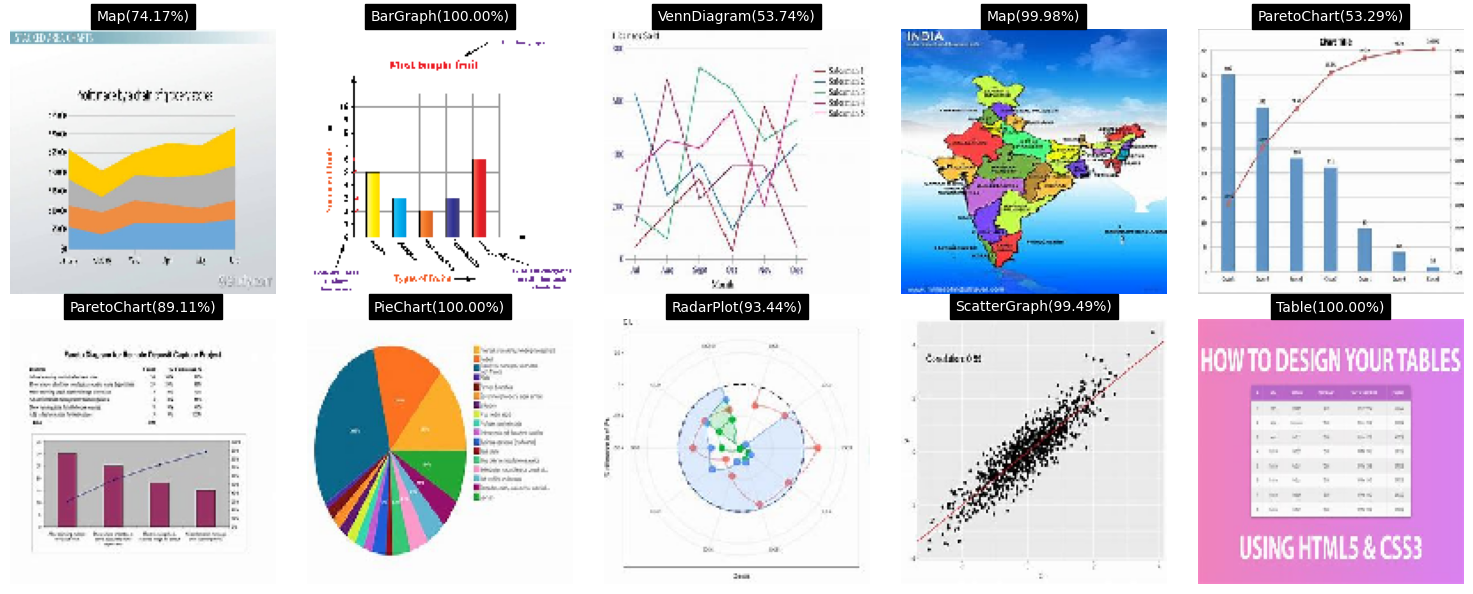

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import math

class_names = list(test_gen.class_indices.keys())
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
total_samples = test_gen.samples
cols = 5
rows = math.ceil(total_samples / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()
for idx in range(total_samples):
    img = test_gen[idx][0][0] if total_samples == 1 else test_gen[idx // test_gen.batch_size][0][idx % test_gen.batch_size]
    pred_probs = predictions[idx]
    predicted_index = np.argmax(pred_probs)
    predicted_label = class_names[predicted_index]
    confidence = np.max(pred_probs) * 100

    ax = axes[idx]
    ax.imshow(img.squeeze(), cmap='gray' if test_gen.color_mode == 'grayscale' else None)
    ax.axis('off')
    ax.set_title(f"{predicted_label}({confidence:.2f}%)", fontsize=10, backgroundcolor='black', color='white')
for ax in axes[total_samples:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [316]:
# Get true labels
y_true = test_gen.classes

# Predict class probabilities
y_pred_probs = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


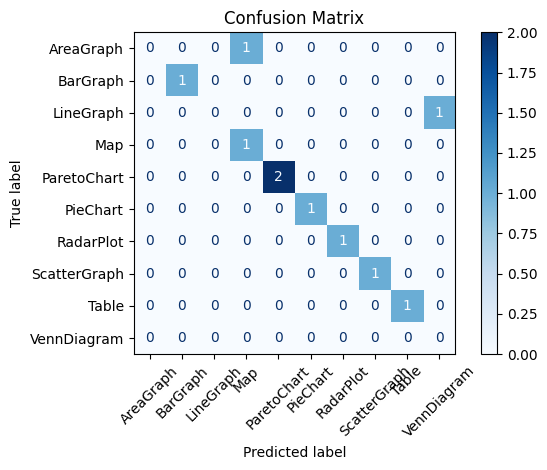

In [318]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
